In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager
import numpy as np
import h5py as h5
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path
import matplotlib.pyplot as plt
import pyproj
from pyproj import Proj
from pyproj import Transformer
import pandas as pd
import argparse
import os
import subprocess
import time
from pyod.models.knn import KNN
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

In [2]:
### Set parameters
# Define variables and location
data_path = '/Users/brian.h.lee/Desktop/icesat/data/raw/processed_ATL03_20200312201759_11780601_004_01.h5'
output_path = '/Users/brian.h.lee/Desktop/icesat/images'
laser_number = '1'
location = 'Cuba'
epsg_code = 'epsg:32617'

# Set resolution (in m)
lat_resolution = 10
height_resolution = 0.5

In [3]:
def OrthometricCorrection(lat, lon, Z, epsg):
    # transform ellipsod (WGS84) height to orthometric height
    transformerh = Transformer.from_crs("epsg:4326", "epsg:3855")
    Y_egm08, X_egm08, Z_egm08 = transformerh.transform(lat, lon, Z)
    
    # transform WGS84 proj to local UTM
    myProj = Proj(epsg)
    Y_utm, X_utm = myProj(lat, lon)
    
    return Y_utm, X_utm, Z_egm08

def ReadATL03(h5_file, laser_num):
    # Read File
    f = h5.File(h5_file,'r')
    
    # Select a laser
    orientation = f['/orbit_info/sc_orient'][0]
    # selects the strong beams only [we can include weak beams later on]
    orientDict = {0:'l', 1:'r', 21:'error'}
    laser = 'gt' + laser_num + orientDict[orientation]
    
    # Read in the required photon level data
    photon_h = f['/' + laser + '/heights/h_ph'][...,]
    latitude = f['/' + laser + '/heights/lat_ph'][...,]
    longitude = f['/' + laser + '/heights/lon_ph'][...,]
    conf = f['/' + laser + '/heights/signal_conf_ph/'][...,0]

    # params needed for refraction correction
    
    ref_elev = f['/' + laser + '/geolocation/ref_elev'][...,]
    ref_azimuth = f['/' + laser + '/geolocation/ref_azimuth'][...,]
    ph_index_beg = f['/' + laser + '/geolocation/ph_index_beg'][...,]
    segment_id = f['/' + laser + '/geolocation/segment_id'][...,]
    
    return latitude, longitude, photon_h, conf, ref_elev, ref_azimuth, ph_index_beg, segment_id


def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("-i", "--input", type=str, help="Specify the input ICESAT H5 file")
    parser.add_argument("-l", "--laser", type=str, help="Specify the ICESAT-2 laser number (1, 2 or 3)")
    parser.add_argument("-e", "--epsg_num", type=int, help="Specify the UTM Zone EPSG code (www.spatialreference.org)")
    #parser.add_argument("-wt", "--waterTemp", type=float, help="Specify the water temperature in degrees C")
    
    args = parser.parse_args()
    
    if args.input == None:
        print('MISSING H5')
        os._exit(1)
    elif args.laser == None:
        print('MISSING LASER NUMBER')
        os._exit(1)
    elif args.epsg_num == None:
        print('MISSING UTM ZONE')
        os._exit(1)

    latitude, longitude, photon_h = ReadATL03(args.input, args.laser)
    
    lat_utm, lon_utm, photon_h = OrthometricCorrection(latitude, longitude, photon_h, args.epsg)
    
# Snippet by Eric Guenther (via Amy N.) for assigning photons to a segment
def getAtl03SegID(atl03_ph_index_beg, atl03_segment_id, atl03_heights_len): 
    
    # We need to know spacecraft orbin info, which is provided across segments. This first function assigns photons to the segmenet they belong to. We end up making a new array
    # that has more points to match the photon. Segment is defined as every 100m in the long track.
    
    # Filter all data where atl03_ph_index starts at 0 (0 indicates errors)
    indsNotZero = atl03_ph_index_beg != 0
    atl03_ph_index_beg = atl03_ph_index_beg[indsNotZero]
    atl03_segment_id = atl03_segment_id[indsNotZero]
    
    # Subtract 1 from ph_index_beg to start at python 0th pos
    atl03_ph_index_beg = atl03_ph_index_beg - 1
    
    # Sometimes the ph_index_beg is not at the 0th position, it is is not,
    # add it in and then add the associated segment id
    # Warning, this is assuming that the segment id for the points are from
    # the segment id directly before it, this assumption might fail but I have
    # not come across a case yet where it does.  If you want to play it safe
    # you could comment this section out and then if the first position is not
    # 0 then all photons before the first position will not be assigned a
    # segment id.
    # if atl03_ph_index_beg[0] != 0:
    #     atl03_ph_index_beg = np.append(0,atl03_ph_index_beg)
    #     first_seg_id = atl03_segment_id[0] -1
    #     atl03_segment_id = np.append(first_seg_id,atl03_segment_id)
    
    
    # Append atl03_height_len to end of array for final position
    atl03_ph_index_beg = np.append(atl03_ph_index_beg,atl03_heights_len)
    
    # Make array equal to the length of the atl03_heights photon level data
    ph_segment_id = np.zeros(atl03_heights_len)
    
    # Iterate through ph_index_beg, from the first to second to last number
    # and set the photons between ph_index_beg i to ph_index_beg i + 1 to
    # segment id i
    for i in range(0,len(atl03_ph_index_beg) - 1):
        ph_segment_id[atl03_ph_index_beg[i]:atl03_ph_index_beg[i+1]] = atl03_segment_id[i]
    
    # Return list of segment_id at the photon level
    return ph_segment_id
def bin_data(dataset, lat_res, height_res):
    
    # Calculate number of bins required
    lat_bin_number = round(abs(dataset['latitude'].min() - dataset['latitude'].max())/lat_res)
    height_bin_number = round(abs(dataset['photon_height'].min() - dataset['photon_height'].max())/height_res)
    
    dataset1 = dataset
    # Cut lat bins
    lat_bins = pd.cut(dataset['latitude'], lat_bin_number, labels = np.array(range(lat_bin_number)))
    # Add bins to dataframe
    dataset1['lat_bins'] = lat_bins
    # Cut height bins
    height_bins = pd.cut(dataset['photon_height'], height_bin_number, labels = np.round(np.linspace(dataset['photon_height'].min(), dataset['photon_height'].max(), num=height_bin_number), decimals = 1))
    # Add height bins to dataframe
    dataset1['height_bins'] = height_bins
    dataset1 = dataset1.reset_index(drop=True)

    return dataset1

def get_sea_height(binned_data):
    # Create sea height list
    sea_height = []
    
    # Group data by latitude
    binned_data_sea = binned_data[(binned_data['photon_height'] > -1)] # Filter out subsurface data
    grouped_data = binned_data_sea.groupby(['lat_bins'], group_keys=True)
    data_groups = dict(list(grouped_data))
    
    # Loop through groups and return average sea height
    for k,v in data_groups.items():
        # Create new dataframe based on occurance of photons per height bin
        new_df = pd.DataFrame(v.groupby('height_bins').count())
        # Return the bin with the highest count
        largest_h_bin = new_df['latitude'].argmax()
        # Select the index of the bin with the highest count
        largest_h = new_df.index[largest_h_bin]
        # Calculate the median value of all values within this bin
        lat_bin_sea_median = v.loc[v['height_bins']==largest_h, 'photon_height'].median()
        # Append to sea height list
        sea_height.append(lat_bin_sea_median)
        del new_df
    
    return sea_height

def RefractionCorrection(WTemp, WSmodel, Wavelength, Photon_ref_elev, Ph_ref_azimuth, PhotonZ, PhotonX, PhotonY, Ph_Conf):
    
    # WTemp; there is python library that pulls water temp data 
    # WSmodel is the value surface height
    # Wavelength is fixed
    
    
    # Only process photons below water surface model
    PhotonX = PhotonX[PhotonZ<=WSmodel]
    PhotonY = PhotonY[PhotonZ<=WSmodel]
    Photon_ref_elev = Photon_ref_elev[PhotonZ<=WSmodel]
    Ph_ref_azimuth = Ph_ref_azimuth[PhotonZ<=WSmodel]
    Ph_Conf = Ph_Conf[PhotonZ<=WSmodel]
    PhotonZ = PhotonZ[PhotonZ<=WSmodel]
    
    # water temp for refraction correction
    WaterTemp= WTemp
    
    # Refraction coefficient #
    a = -0.000001501562500
    b = 0.000000107084865
    c = -0.000042759374989
    d = -0.000160475520686
    e = 1.398067112092424
    wl = Wavelength
    
    # refractive index of air
    n1 = 1.00029
    
    # refractive index of water
    n2 = (a*WaterTemp**2) + (b*wl**2) + (c*WaterTemp) + (d*wl) + e
    
    # assumption is 0.25416
    # This example is refractionCoef = 0.25449
    # 1.00029 is refraction of air constant
    CorrectionCoef = (1-(n1/n2))
    #########################
    
    #read photon ref_elev to get theta1
    theta1 = np.pi/2 - Photon_ref_elev
    
    # eq 1. Theta2
    theta2 = np.arcsin(((n1*np.sin(theta1))/n2))
    
    # eq 3. S
    # Approximate water Surface = 1.5
    # D  = raw uncorrected depth
    D = WSmodel - PhotonZ
    
    # For Triangle DTS
    S = D/np.cos(theta1)
    
    # eq 2. R
    R = (S*n1)/n2
    Gamma = (np.pi/2)-theta1
    
    # For triangle RPS
    # phi is an angle needed
    phi = theta1-theta2
    
    # P is the difference between raw and corrected YZ location
    P = np.sqrt(R**2 + S**2 - 2*R*S*np.cos(phi))
    
    # alpha is an angle needed
    alpha = np.arcsin((R*np.sin(phi))/P)
    
    # Beta angle needed for Delta Y an d Delta Z
    Beta = Gamma - alpha
    
    # Delta Y
    DY = P*np.cos(Beta)
    
    # Delta Z
    DZ = P*np.sin(Beta)
    
    # Delta Easting
    DE = DY*np.sin(Ph_ref_azimuth)
    
    # Delta Northing
    DN = DY*np.cos(Ph_ref_azimuth)
    
    outX = PhotonX + DE
    outY = PhotonY + DN
    outZ = PhotonZ + DZ
    '''
        print('\nFor selected Bathy photon:')
        print('lat = ', PhotonY[9000])
        print('long = ', PhotonX[9000])
        print('Raw Depth = ', PhotonZ[9000])
        print('D = ', D[9000])
        
        print('ref_elev = ', Photon_ref_elev[9000])
        
        print('Delta Easting = ', DE[9000])
        print('Delta Northing = ', DN[9000])
        print('Delta Z = ', DZ[9000])
        '''
    return(outX, outY, outZ, Ph_Conf, PhotonX, PhotonY, PhotonZ, Ph_ref_azimuth, Photon_ref_elev) # We are most interested in outx, outy, outz



In [4]:
latitude, longitude, photon_h, conf, ref_elev, ref_azimuth, ph_index_beg, segment_id = ReadATL03(data_path, laser_number)
lat_utm, lon_utm, photon_h = OrthometricCorrection(latitude, longitude, photon_h, epsg_code)

###### Get ref-elev and ref_azimuth at photon level
# Get length of photon array
heights_len = len(photon_h)
# Assign segment id to each photon for the segment it is in
Ph_segment_id = getAtl03SegID(ph_index_beg, segment_id, heights_len)
# Cast as an int
Ph_segment_id = Ph_segment_id.astype(np.int)
# Ref_elev on a per photon level (assign seg ref_elev to photons)
Ph_ref_elev = ref_elev[np.searchsorted(segment_id, Ph_segment_id)]
# Ref_azimuth on a per photon level (assign seg ref_azimuth to photons)
Ph_ref_azimuth = ref_azimuth[np.searchsorted(segment_id, Ph_segment_id)]

# Aggregate data into dataframe
dataset_sea = pd.DataFrame({'latitude': lat_utm, 'longitude': lon_utm, 'photon_height': photon_h, 'confidence':conf, 'ref_elevation':Ph_ref_elev, 'ref_azminuth':Ph_ref_azimuth}, 
                       columns=['latitude', 'longitude', 'photon_height', 'confidence', 'ref_elevation', 'ref_azminuth'])

##### Filter data that should not be analyzed
# Filter for quality flags
dataset_sea1 = dataset_sea[(dataset_sea.confidence != 0)  & (dataset_sea.confidence != 1)]
# Filter for elevation range
dataset_sea1 = dataset_sea1[(dataset_sea1['photon_height'] > -40) & (dataset_sea1['photon_height'] < 5)]
# Focus on specific latitude
# dataset_sea1 = dataset_sea1[(dataset_sea1['latitude'] > 1300000) & (dataset_sea1['latitude'] < 1350000)]

binned_data_sea = bin_data(dataset_sea1, lat_resolution, height_resolution)
sea_height = get_sea_height(binned_data_sea)

# Set sea height
WSHeight = np.nanmedian(sea_height)

# Set sea temperature
waterTemp = 20

RefX, RefY, RefZ, RefConf, rawX, rawY, rawZ, ph_ref_azi, ph_ref_elev = RefractionCorrection(waterTemp, WSHeight, 532, dataset_sea1.ref_elevation, dataset_sea1.ref_azminuth, dataset_sea1.photon_height, dataset_sea1.longitude, dataset_sea1.latitude, dataset_sea1.confidence) # XYZ are what we're interested in .

# Create new dataframe with refraction corrected data
dataset_bath = pd.DataFrame({'latitude': rawY, 'longitude': rawX, 'cor_latitude':RefY, 'cor_longitude':RefX, 'cor_photon_height':RefZ, 'photon_height': rawZ, 'confidence':RefConf}, 
                       columns=['latitude', 'longitude', 'photon_height', 'cor_latitude','cor_longitude', 'cor_photon_height', 'confidence'])

In [10]:
dataset_bath

,latitude,longitude,photon_height,cor_latitude,cor_longitude,cor_photon_height,confidence
3,1.355845e+06,-1.018236e+07,0.634943,1.355845e+06,-1.018236e+07,0.648873,-1
4,1.355845e+06,-1.018236e+07,0.333437,1.355845e+06,-1.018236e+07,0.424055,-1
6,1.355845e+06,-1.018236e+07,0.606900,1.355845e+06,-1.018236e+07,0.627963,-1
7,1.355845e+06,-1.018236e+07,0.384139,1.355845e+06,-1.018236e+07,0.461861,-1
10,1.355845e+06,-1.018236e+07,-24.772859,1.355845e+06,-1.018236e+07,-18.296455,-1
...,...,...,...,...,...,...,...
967935,1.330725e+06,-1.020250e+07,-5.316247,1.330725e+06,-1.020250e+07,-3.788627,-1
967936,1.330725e+06,-1.020250e+07,-21.500999,1.330725e+06,-1.020250e+07,-15.856775,-1
967937,1.330725e+06,-1.020250e+07,-11.190980,1.330725e+06,-1.020250e+07,-8.169117,-1
967938,1.330725e+06,-1.020250e+07,-10.331857,1.330725e+06,-1.020250e+07,-7.528513,-1


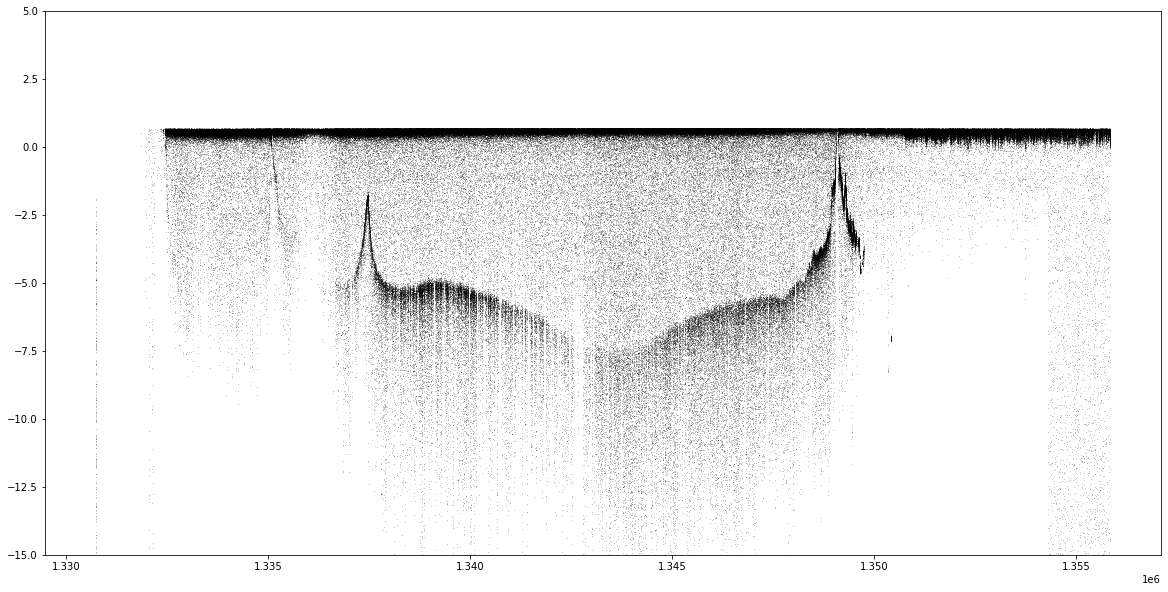

In [11]:
fig = plt.rcParams["figure.figsize"] = (20,10)
plt.scatter(x=dataset_bath.cor_latitude, y = dataset_bath.cor_photon_height, marker='o', lw=0, s=0.5, alpha = 0.3, c = 'black', label = 'Corrected photon height')
plt.ylim(top = 5, bottom = -15)
plt.show()

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_bath[['cor_latitude','cor_photon_height']] = scaler.fit_transform(dataset_bath[['cor_latitude','cor_photon_height']])
dataset_bath[['cor_latitude','cor_photon_height']].head()

,cor_latitude,cor_photon_height
3,0.999993,0.998654
4,0.999994,0.991241
6,0.999990,0.997964
7,0.999990,0.992488
10,1.000000,0.374011


In [14]:
X1 = dataset_bath['cor_latitude'].values.reshape(-1,1)
X2 = dataset_bath['cor_photon_height'].values.reshape(-1,1)

In [16]:
X = np.concatenate((X1,X2),axis=1)

xx , yy = np.meshgrid(np.linspace(0, 1 , 200), np.linspace(0, 1, 200))

In [17]:
clf = KNN()
clf.fit(X)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

Estimated Outliers:  (435865,)


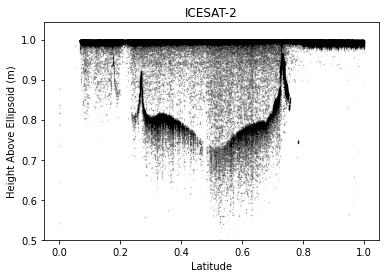

<Figure size 432x288 with 0 Axes>

In [19]:
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1

# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
print("Estimated Outliers: ", np.shape(y_pred))

plt.clf()
plt.scatter(dataset_bath.cor_latitude[y_pred==0], dataset_bath.cor_photon_height[y_pred==0], alpha=0.1, s=0.1, c='black')
plt.title('ICESAT-2')
plt.ylabel('Height Above Ellipsoid (m)')
plt.xlabel('Latitude')
# plt.ylim(top=upperLimit)
plt.ylim(bottom=0.5)
ax = plt.gca()
#ax.set_facecolor('#f0f8ff')
#ax.set_xlim([args.YAxisMin,args.YAxisMax])
# plt.savefig(os.path.join(inDir,FigName + '_KNN.png'), dpi=500, format='PNG')
plt.show()
plt.clf()

In [20]:

# copy of dataframe
dfx = pd.DataFrame({'Latitude':dataset_bath['cor_latitude'],'Photon':dataset_bath['cor_photon_height']})
dfx['outlier'] = y_pred.tolist()

In [22]:
Latitude = dataset_bath['cor_latitude']
Longitude = dataset_bath['cor_longitude']
Photon = dataset_bath['cor_photon_height']

In [23]:
# IX1 - inlier feature 1,  IX2 - inlier feature 2
# indexes the X and Y data by the false (inlier) data from the prediction
IX1 =  np.array(dfx['Latitude'][dfx['outlier'] == 0]).reshape(-1,1)
IX_1 = Latitude[dfx['outlier'].values == 0]
IY_1 = Longitude[dfx['outlier'].values == 0]
IX2 =  np.array(dfx['Photon'][dfx['outlier'] == 0]).reshape(-1,1)
IX_2 = Photon[dfx['outlier'].values == 0]


In [25]:
# OX1 - outlier feature 1, OX2 - outlier feature 2
# indexes the X and Y data by the true (outlier) data from the prediction
OX1 =  dfx['Latitude'][dfx['outlier'] == 1].values.reshape(-1,1)
OX2 =  dfx['Photon'][dfx['outlier'] == 1].values.reshape(-1,1)

print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, 'KNN')

OUTLIERS :  33085 INLIERS :  402780 KNN


In [54]:
# threshold value to consider a datapoint inlier or outlier
threshold = stats.scoreatpercentile(scores_pred,100 * 0.22)

# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)


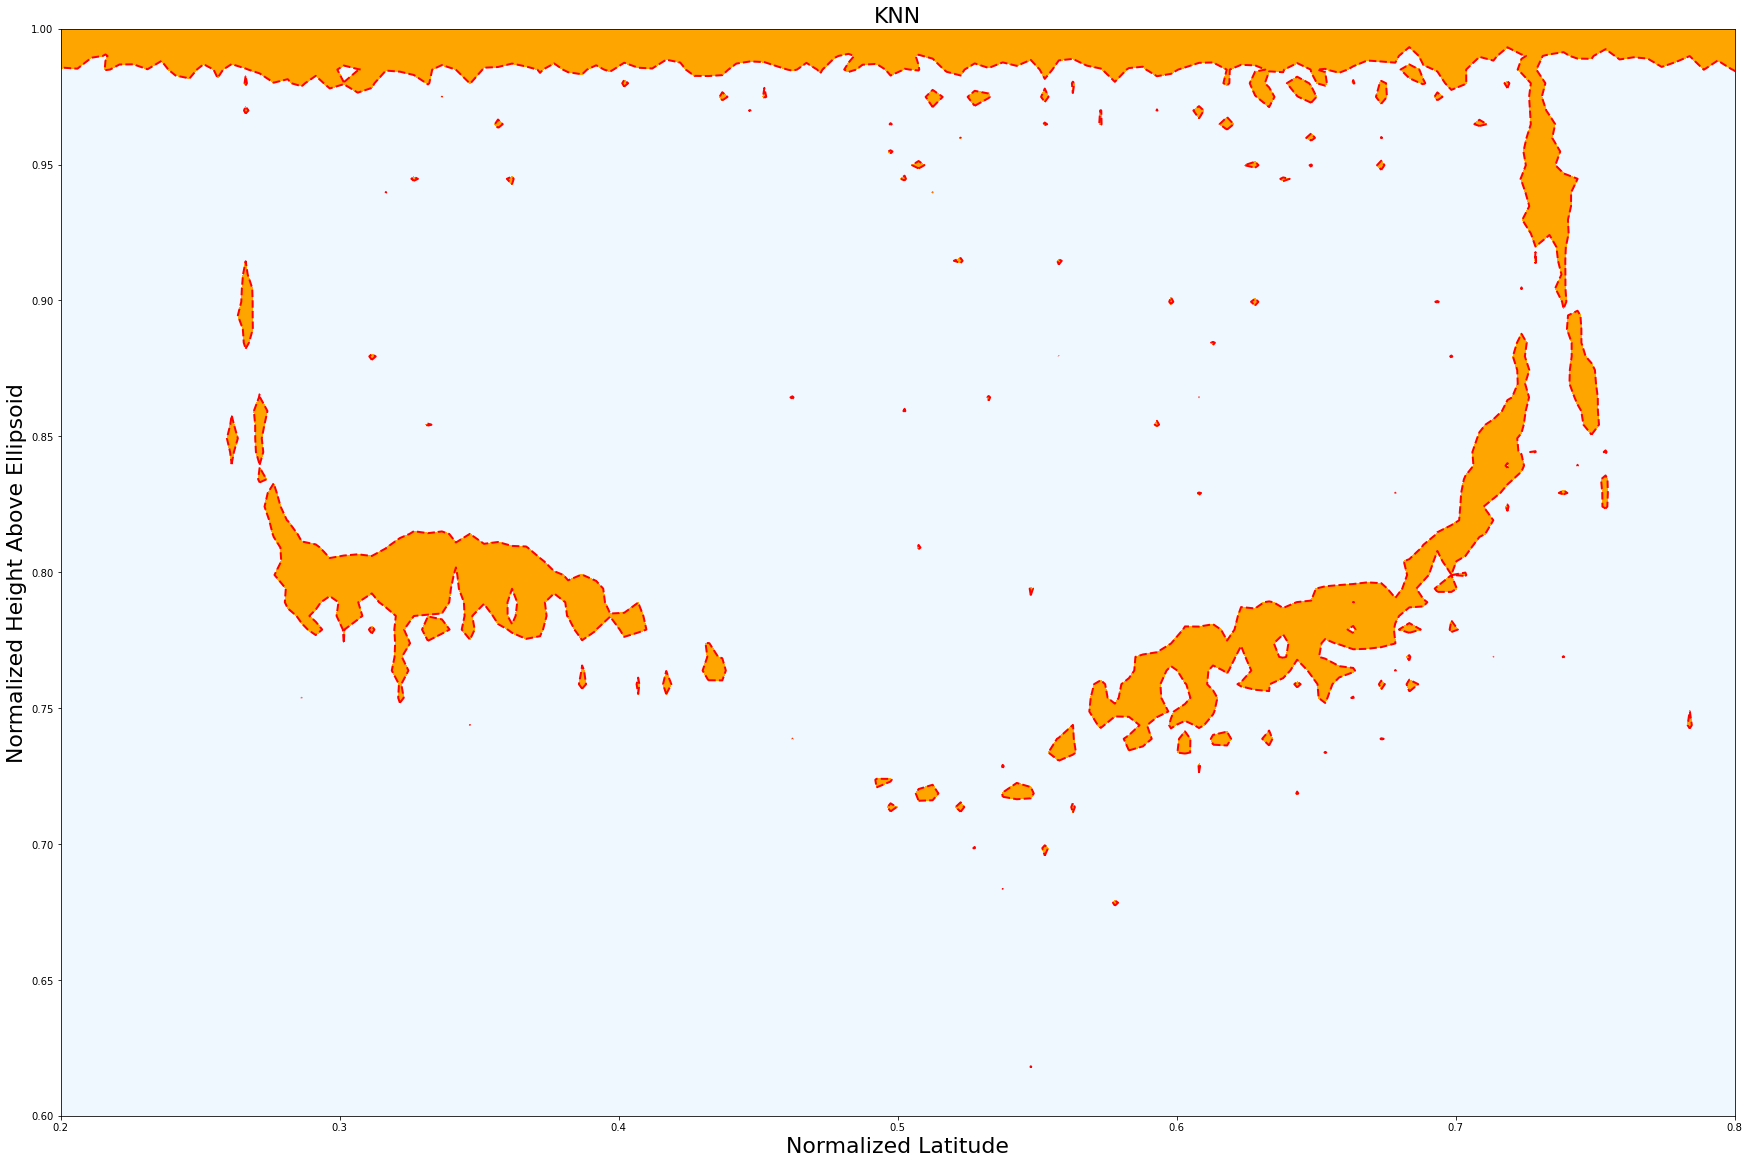

In [56]:
# fill blue map colormap from minimum anomaly score to threshold value
#plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
# Replace contour with blue background

ax = plt.gca()
plt.rcParams["figure.figsize"] = (30,20)
ax.set_facecolor('#f0f8ff')

# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')

# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')

# b = plt.scatter(IX1,IX2, c='white',s=3, edgecolor='k')

# c = plt.scatter(OX1,OX2, c='black',s=3, edgecolor='k')

plt.axis('tight')

# loc=2 is used for the top left corner
# plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],prop=mpl.font_manager.FontProperties(size=22),loc=2)


plt.xlim((0.2, 0.8))
plt.ylim((0.6, 1))
plt.title('KNN', fontsize=22)
plt.xlabel('Normalized Latitude', fontsize=22)
plt.ylabel('Normalized Height Above Ellipsoid', fontsize=22)
# plt.savefig(os.path.join(inDir,FigName + '_KNN_Norm.png'), dpi=500, format='PNG')
plt.show()

Text(0, 0.5, 'F2')

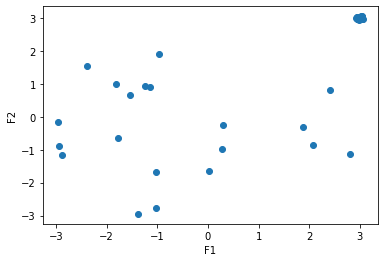

In [6]:
### Tutorial from https://www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/

from pyod.utils.data import generate_data, get_outliers_inliers

#generate random data with two features
X_train, Y_train = generate_data(n_train=200,train_only=True, n_features=2)

# by default the outlier fraction is 0.1 in generate data function 
outlier_fraction = 0.1

# store outliers and inliers in different numpy arrays
x_outliers, x_inliers = get_outliers_inliers(X_train,Y_train)

n_inliers = len(x_inliers)
n_outliers = len(x_outliers)

#separate the two features and use it to plot the data 
F1 = X_train[:,[0]].reshape(-1,1)
F2 = X_train[:,[1]].reshape(-1,1)

# create a meshgrid 
xx , yy = np.meshgrid(np.linspace(-10, 10, 200), np.linspace(-10, 10, 200))

# scatter plot 
plt.scatter(F1,F2)
plt.xlabel('F1')
plt.ylabel('F2') 

In [7]:
classifiers = {
     'Angle-based Outlier Detector (ABOD)'   : ABOD(contamination=outlier_fraction),
     'K Nearest Neighbors (KNN)' :  KNN(contamination=outlier_fraction)
}

No of Errors :  Angle-based Outlier Detector (ABOD) 0
No of Errors :  K Nearest Neighbors (KNN) 0


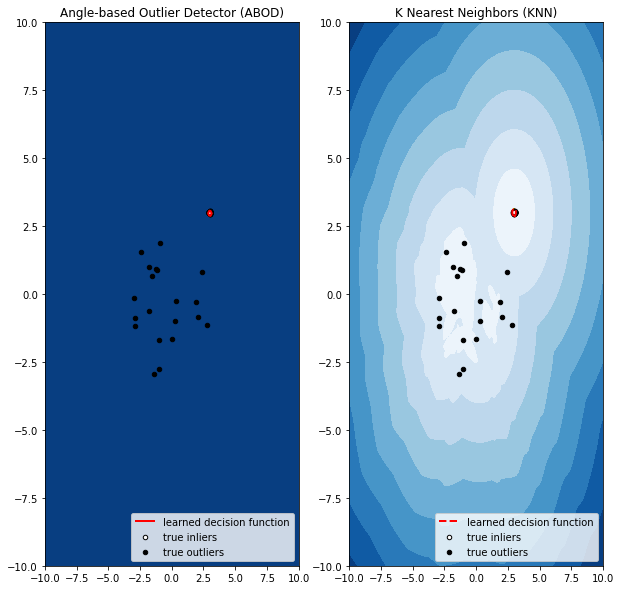

In [8]:
#set the figure size
plt.figure(figsize=(10, 10))

for i, (clf_name,clf) in enumerate(classifiers.items()) :
    # fit the dataset to the model
    clf.fit(X_train)

    # predict raw anomaly score
    scores_pred = clf.decision_function(X_train)*-1

    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X_train)

    # no of errors in prediction
    n_errors = (y_pred != Y_train).sum()
    print('No of Errors : ',clf_name, n_errors)

    # rest of the code is to create the visualization

    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 *outlier_fraction)

    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)

    subplot = plt.subplot(1, 2, i + 1)

    # fill blue colormap from minimum anomaly score to threshold value
    subplot.contourf(xx, yy, Z, levels = np.linspace(Z.min(), threshold, 10),cmap=plt.cm.Blues_r)

    # draw red contour line where anomaly score is equal to threshold
    a = subplot.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')

    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')

    # scatter plot of inliers with white dots
    b = subplot.scatter(X_train[:-n_outliers, 0], X_train[:-n_outliers, 1], c='white',s=20, edgecolor='k') 
    # scatter plot of outliers with black dots
    c = subplot.scatter(X_train[-n_outliers:, 0], X_train[-n_outliers:, 1], c='black',s=20, edgecolor='k')
    subplot.axis('tight')

    subplot.legend(
        [a.collections[0], b, c],
        ['learned decision function', 'true inliers', 'true outliers'],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc='lower right')

    subplot.set_title(clf_name)
    subplot.set_xlim((-10, 10))
    subplot.set_ylim((-10, 10))
plt.show() 

In [ ]:
#! /usr/bin/env python

''' Author: Nathan Thomas
    Date: 27/08/2019
    Version: 1.2
    Update 1.1: Amended to subset based on Latitude not photon ID
    Update 1.2: Added PYOD KNN algorithm for outlier rmeoval
    #######
    Copyright 2019 Natha M Thomas
    
    Permission is hereby granted, free of charge, to any person obtaining a copy
    of this software and associated documentation files (the "Software"), to deal
    in the Software without restriction, including without limitation the rights
    to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
    copies of the Software, and to permit persons to whom the Software is
    furnished to do so, subject to the following conditions:
    
    The above copyright notice and this permission notice shall be included in all
    copies or substantial portions of the Software.
    
    THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
    IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
    FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
    AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
    LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
    OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
    SOFTWARE.'''

import h5py
from osgeo import gdal
import numpy as np
import pandas as pd
import subprocess
import os
import argparse

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams





def ICESAT2GRD(args):
    # File path to ICESat-2h5 file
    H5 = args.input
    # Get the filepath where the H5 is stored and filename
    inDir = '/'.join(H5.split('/')[:-1])
    Name = H5.split('/')[-1].split('.')[0]

    # open file
    f = h5py.File(H5,'r')

    # set up blank lists
    Latitude = []
    Longitude =[]
    MaxCanopy = []

    # Set the names of the laser
    # For water penetration gt2l is the strong middle beam
    # The middle beam is nadir so diffraction at water surface is reduced
    # Underwater depths are more accurate with less diffraction (Parrish et al., 2019)
    # Available lasers: 'gt1r', 'gt1l', 'gt2r', 'gt2l', 'gt3r', 'gt3l'
    # Automatically checks spacecraft orientation and chooses the strong laser
    
    # Orbit direction
    orientation = f['/' + 'orbit_info/sc_orient'][0]
    
    orientDict = {0:'gt2l', 1:'gt2r', 21:'error'}
    
    Laser = orientDict[orientation]
    print('Laser = ', Laser)
    
    # Set the names of the laser
    # For water penetration gt2l is the strong middle beam
    # The middle beam is nadir so diffraction at water surface is reduced
    # Underwater depths are more accurate with less diffraction (Parrish et al., 2019)
    # Available lasers: 'gt1r', 'gt1l', 'gt2r', 'gt2l', 'gt3r', 'gt3l'

    # For each laser read the data and append to its list
    Latitude.append(f['/' + Laser + '/heights/lat_ph/'][...,].tolist())
    Longitude.append(f['/' + Laser + '/heights/lon_ph/'][...,].tolist())
    MaxCanopy.append(f['/' + Laser + '/heights/h_ph/'][...,].tolist())
    
    # Flatten the array to 1 dimension
    Latitude=np.array(Latitude).flatten()
    Longitude=np.array(Longitude).flatten()
    MaxCanopy=np.array(MaxCanopy).flatten()
    
    # Set up arguments and defaults
    if args.startID==None:
        StartingNumber = np.amin(Latitude) # Default 0
    else:
        StartingNumber = args.startID
    
    if args.endID==None:
        EndingNumber = np.amax(Latitude) # Default -1
    else:
        EndingNumber = args.endID
    
    if args.density==None:
        SamplingInterval = 20 # Default 20
    else:
        SamplingInterval = args.density

    if args.YAxisMin==None:
        lowerLimit = -100 # Default -100
    else:
        lowerLimit = float(args.YAxisMin)

    if args.YAxisMax==None:
        upperLimit = 100 # Default -100
    else:
        upperLimit = float(args.YAxisMax)

    print('Total Number of photons = ', np.shape(Latitude)[0])

    # Create a handy ID label for each point
    ID = np.arange(1, np.shape(MaxCanopy)[0]+1, 1)

    # subset the arrays based on the latitudesrequired
    ID = np.where((Latitude < StartingNumber) | (Latitude > EndingNumber), 0, ID)
    MaxCanopy = np.where((Latitude < StartingNumber) | (Latitude > EndingNumber), 0, MaxCanopy)
    Longitude = np.where((Latitude < StartingNumber) | (Latitude > EndingNumber), 0, Longitude)
    Latitude = np.where((Latitude < StartingNumber) | (Latitude > EndingNumber), 0, Latitude)

    # Get rid of 0 values
    ID = ID[ID!=0]
    MaxCanopy = MaxCanopy[MaxCanopy!=0]
    Longitude = Longitude[Longitude!=0]
    Latitude = Latitude[Latitude!=0]

    print('Processing ', np.shape(Latitude)[0], ' photons')

    ID = ID[::SamplingInterval]
    MaxCanopy = MaxCanopy[::SamplingInterval]
    Longitude = Longitude[::SamplingInterval]
    Latitude = Latitude[::SamplingInterval]

    
    # MAKE PLOT
    plt.scatter(Latitude, MaxCanopy, alpha=0.1, s=0.1, c='black')
    plt.title('ICESAT-2')
    plt.ylabel('Height Above Ellipsoid (m)')
    plt.xlabel('Latitude')
    plt.ylim(top=upperLimit)
    plt.ylim(bottom=lowerLimit)
    plt.xlim(args.startID, args.endID)
    #plt.xlim(40.714, 40.725)
    fig1 = plt.gcf()
    

    # Set up new consistent output name
    FigName = Name + '_' + Laser + '_' + str(StartingNumber) + '_' + str(EndingNumber)
    
    # Check whether to save plot or not
    if args.SaveOutput == 1:
        fig1.savefig(os.path.join(inDir,FigName + '.png'), dpi=500, format='PNG')
        plt.show()
        # Write out to a CSV
        print('Saving Outputs')
        out=pd.DataFrame(
                         {'X': Longitude,
                         'Y': Latitude,
                         'ID':ID,
                         'MaxCanopy':MaxCanopy
                         })

        # Write out to a csv
        print('Creating CSV...')
        CSVName = Name + '_' + Laser + '_' + str(StartingNumber) + '_' + str(EndingNumber)
        out.to_csv(os.path.join(inDir, CSVName + '.csv'),index=False, encoding="utf-8-sig")

        # Convert the csv to a shp
        print('Creating SHP...')
        subprocess.call('ogr2ogr -s_srs EPSG:4326 -t_srs EPSG:4326 -oo X_POSSIBLE_NAMES=X -oo Y_POSSIBLE_NAMES=Y  -f "ESRI Shapefile" ' + os.path.join(inDir, CSVName + '.shp') + ' ' + os.path.join(inDir, CSVName + '.csv'), shell=True)
    else:
        'here'
        plt.show()

    if args.OutlierDetection == True:
        from pyod.models.knn import KNN
        from pyod.utils.data import generate_data
        from pyod.utils.data import evaluate_print
        from pyod.utils.example import visualize
        from scipy import stats
        from sklearn.preprocessing import MinMaxScaler
        
        MaxCanopy = np.where((MaxCanopy>upperLimit) | (MaxCanopy<lowerLimit), -9999, MaxCanopy)
        
        Latitude = Latitude[MaxCanopy!=-9999]
        Longitude = Longitude[MaxCanopy!=-9999]
        MaxCanopy = MaxCanopy[MaxCanopy!=-9999]
        
        df = pd.DataFrame({'Latitude':Latitude,'MaxCanopy':MaxCanopy})

        scaler = MinMaxScaler(feature_range=(0, 1))
        df[['Latitude','MaxCanopy']] = scaler.fit_transform(df[['Latitude','MaxCanopy']])
        df[['Latitude','MaxCanopy']].head()

        X1 = df['Latitude'].values.reshape(-1,1)
        X2 = df['MaxCanopy'].values.reshape(-1,1)

        X = np.concatenate((X1,X2),axis=1)

        xx , yy = np.meshgrid(np.linspace(0, 1 , 200), np.linspace(0, 1, 200))

        outliers_fraction = args.OutlierFraction

        clf = KNN(contamination=outliers_fraction)
        clf.fit(X)
        # predict raw anomaly score
        scores_pred = clf.decision_function(X) * -1

        # prediction of a datapoint category outlier or inlier
        y_pred = clf.predict(X)
        n_inliers = len(y_pred) - np.count_nonzero(y_pred)
        n_outliers = np.count_nonzero(y_pred == 1)
        print("Estimated Outliers: ", np.shape(y_pred))

        plt.clf()
        plt.scatter(Latitude[y_pred==0], MaxCanopy[y_pred==0], alpha=0.1, s=0.1, c='black')
        plt.title('ICESAT-2')
        plt.ylabel('Height Above Ellipsoid (m)')
        plt.xlabel('Latitude')
        plt.ylim(top=upperLimit)
        plt.ylim(bottom=lowerLimit)
        ax = plt.gca()
        #ax.set_facecolor('#f0f8ff')
        #ax.set_xlim([args.YAxisMin,args.YAxisMax])
        plt.savefig(os.path.join(inDir,FigName + '_KNN.png'), dpi=500, format='PNG')
        plt.show()
        plt.clf()

        plt.figure(figsize=(10, 10))
    
        # copy of dataframe
        dfx = df
        dfx['outlier'] = y_pred.tolist()

        # IX1 - inlier feature 1,  IX2 - inlier feature 2
        # indexes the X and Y data by the false (inlier) data from the prediction
        IX1 =  np.array(dfx['Latitude'][dfx['outlier'] == 0]).reshape(-1,1)
        IX_1 = Latitude[dfx['outlier'].values == 0]
        IY_1 = Longitude[dfx['outlier'].values == 0]
        IX2 =  np.array(dfx['MaxCanopy'][dfx['outlier'] == 0]).reshape(-1,1)
        IX_2 = MaxCanopy[dfx['outlier'].values == 0]

        # OX1 - outlier feature 1, OX2 - outlier feature 2
        # indexes the X and Y data by the true (outlier) data from the prediction
        OX1 =  dfx['Latitude'][dfx['outlier'] == 1].values.reshape(-1,1)
        OX2 =  dfx['MaxCanopy'][dfx['outlier'] == 1].values.reshape(-1,1)

        print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, 'KNN')

        # threshold value to consider a datapoint inlier or outlier
        threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)

        # decision function calculates the raw anomaly score for every point
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
        Z = Z.reshape(xx.shape)

        # fill blue map colormap from minimum anomaly score to threshold value
        #plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        # Replace contour with blue background
        ax = plt.gca()
        ax.set_facecolor('#f0f8ff')

        # draw red contour line where anomaly score is equal to thresold
        a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')

        # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
        plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')

        b = plt.scatter(IX1,IX2, c='white',s=30, edgecolor='k')

        c = plt.scatter(OX1,OX2, c='black',s=30, edgecolor='k')

        plt.axis('tight')

        # loc=2 is used for the top left corner
        plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],prop=mpl.font_manager.FontProperties(size=22),loc=2)


        plt.xlim((0, 1))
        plt.ylim((0, 1))
        plt.title('KNN', fontsize=22)
        plt.xlabel('Normalized Latitude', fontsize=22)
        plt.ylabel('Normalized Height Above Ellipsoid', fontsize=22)
        plt.savefig(os.path.join(inDir,FigName + '_KNN_Norm.png'), dpi=500, format='PNG')
        plt.show()


def main():
    print("\nICESat2_Bathymertric_profile.py is written by Nathan Thomas (@Nmt28).\nUse '-h' for help and required input parameters\n")
    parser = argparse.ArgumentParser()
    parser.add_argument("-i", "--input", type=str, help="Specify the input ICESAT H5 file")
    parser.add_argument("-s", "--startID", type=float, help="Specify the starting photon latitude (default = min latitude)")
    parser.add_argument("-e", "--endID", type=float, help="Specify the ending photon latitude (default = max latitude)")
    parser.add_argument("-d", "--density", type=int, help="Specify the sampling density (default=20)")
    parser.add_argument("-so", "--SaveOutput", type=int, help="Boolean: True = plot will be saved")
    parser.add_argument("-ymin", "--YAxisMin", type=float, help="Minimum limit on y-axis for plotting (default=-100)")
    parser.add_argument("-ymax", "--YAxisMax", type=float, help="Maximum limit on y-axis for plotting (default=100)")
    parser.add_argument("-od", "--OutlierDetection", type=int, help="Boolean: Specify whether to run KNN outlier detection")
    parser.add_argument("-of", "--OutlierFraction", type=float, help="Boolean: Specify the KNN fraction estimate (Default: 0.3)")
    args = parser.parse_args()

    
    if str(args.input).endswith('.h5'):
        pass
    else:
        print("INPUT ICESAT2 FILE MUST END '.H5'")
        os._exit(1)

    if args.startID == None:
        print("PHOTON LATITUDE START: MIN LATITUDE")
    else:
        print("PHOTON LATITUDE START: " + str(args.startID))

    if args.endID == None:
        print("PHOTON LATITUDE END: MAX LATITUDE")
    else:
        print("PHOTON LATITUDE END: " + str(args.endID))

    if args.density == None:
        print("SAMPLING RATE: 20")
    else:
        print("SAMPLING RATE: " + str(args.density))

    if args.YAxisMin == None:
        print("Y-AXIS MIN: " + str('-100'))
    else:
        print("Y-AXIS MIN: " + str(args.YAxisMin))

    if args.YAxisMax == None:
        print("Y-AXIS MAX: " + str('100'))
    else:
        print("Y-AXIS MAX: " + str(args.YAxisMax))

    if args.OutlierDetection == True:
        print("KNN OD WILL BE RUN")
        print("KNN OD WILL BE LIMITED TO UPPER AND LOWER Y LIMITS")
    else:
        print("KNN OD WILL NOT BE RUN")

    if args.OutlierFraction == None:
        print("KNN OUTLIER FRACTION = 0.35")
    else:
        print("KNN OUTLIER FRACTION = ", args.OutlierFraction)

    ICESAT2GRD(args)


if __name__ == "__main__":
    main()
